In [1]:
import seaborn as sns
sns.set_style("whitegrid")
from process_model import *
from fit_process import *
from scipy.stats import norm
from scipy.stats.mstats import mquantiles
from scipy.stats import ttest_ind
import pickle
import sys
sys.path.append('./scripts')
from scipy.stats import sem
pd.options.display.max_rows = 4000
pd.set_option('display.max_colwidth', 100)

In [932]:
#FIGDEST = '/Users/markant/code/chase_paper/figures'
FIGDEST = '/Users/markant/Dropbox/Apps/ShareLaTeX/CHASE Paper/figures'

# Load data

In [1231]:
data = pd.read_csv('paper/data/markant/results_v3.csv', index_col=0)
data.rename(columns={'sid': 'subject', 'probid': 'problem'}, inplace=True)
data['choice'] = data.choice.apply(lambda c: 1 if c=='B' else 0)

probdf = pd.read_csv('/Users/markant/experiments/exp_chase/chase-v3/static/problems_normal.csv', index_col=0)
probdf['mn_diff'] = probdf['mn_B'] - probdf['mn_A']
probdf['variance'] = probdf['var_A'] # matched variance in both options

problems = {}
for i, row in probdf.iterrows():
    problems[row['id']] = np.array([[row['mn_A'], row['var_A']], 
                                    [row['mn_B'], row['var_B']]])
    
problems_obsvar = {}
for pid in problems:
    obs_var = []
    mu = problems[pid][:,0]
    sigma2 = problems[pid][:,1]/2.
    problems_obsvar[pid] = np.array([[mu[0], sigma2[0]], [mu[1], sigma2[1]]])
    
problems = problems_obsvar

data['p_switch'] = data.n_switch / (data.samplesize - 1)
data.loc[np.isnan(data['p_switch']), 'p_switch'] = 0.

# Test predictions

In [7]:
from scipy.stats import truncnorm

In [401]:
A, B = problems['normal-30']
print A, B

xmin, xmax = -100, 180
lowerA, upperA = (xmin - A[0]) / np.sqrt(A[1]), (xmax - A[0]) / np.sqrt(A[1])
lowerB, upperB = (xmin - B[0]) / np.sqrt(B[1]), (xmax - B[0]) / np.sqrt(B[1])


[  59.  800.] [  68.  800.]


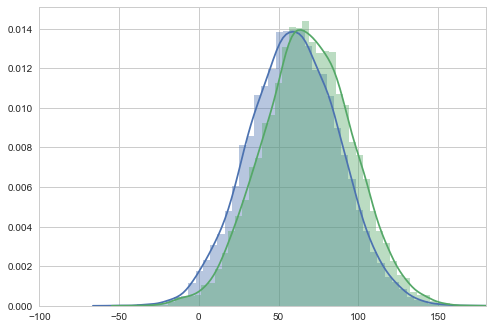

In [402]:
fig, ax = plt.subplots()
sns.distplot(truncnorm.rvs(lowerA, upperA, loc=A[0], scale=np.sqrt(A[1]), size=10000), ax=ax)
sns.distplot(truncnorm.rvs(lowerB, upperB, loc=B[0], scale=np.sqrt(B[1]), size=10000), ax=ax)
ax.set_xlim(-100, 180)
plt.show()

In [1221]:
bfpars[(200,'optional')]

index                                                                                                                 0
Unnamed: 0                                                                                                            0
iteration                                                                                                             0
success                                                                                                            True
nllh                                                                                                            80.2057
k                                                                                                                     5
N                                                                                                                    24
bic                                                                                                             176.302
c_sigma                                 

In [1337]:
pset = data[data.subject==200].problem.values

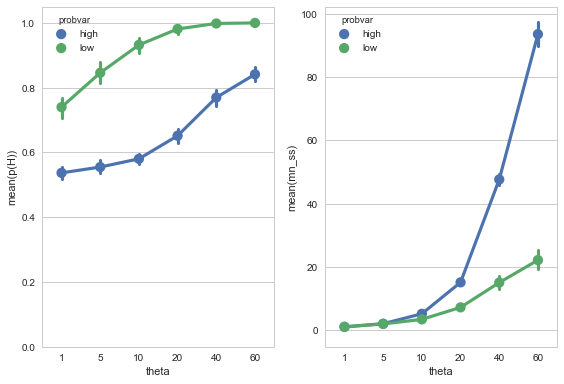

In [1349]:
allresults = {}

pars = {'max_T': 1000,
        'N': 100,
        'tau_trunc': 1,
        'sc2_mean': 1,
        'c_sigma': 5,
       }

m = CHASEProcessModel(problems=problems,
                      problemtype='normal')

thetas = [1, 5, 10, 20, 40, 60]
    
arr = []
for pid in problems:
#for pid in pset:
    pars['probid'] = pid
    for theta in thetas:
        pars['theta'] = theta
        varcond = 'high' if int(problems[pid][0][1]) == 800 else 'low'
        #varcond = 'high' if int(problems[pid][0][1]) == 1600 else 'low'
        
        res = m(problems[pid], pars)
        
        allresults[(pid,theta)] = res
        cp = res['p_resp']
        #ss = res['samplesize'].mean()
        ss = np.median(res['samplesize'])
        arr.append([pid, varcond, theta, cp[1], ss])
        
df = pd.DataFrame(arr, columns=['problem', 'probvar', 'theta', 'p(H)', 'mn_ss'])

fig, ax = plt.subplots(1, 2)
sns.pointplot(x='theta', y='p(H)', hue='probvar', data=df, ax=ax[0])
sns.pointplot(x='theta', y='mn_ss', hue='probvar', data=df, ax=ax[1])
ax[0].set_ylim(0.,1.05)
plt.tight_layout()
plt.show()

In [1046]:
df.groupby(['probvar', 'theta']).agg(np.mean)

p(H)       mn_ss
probvar theta                      
high    1      0.558000    1.665000
        5      0.631667    8.059333
        10     0.731333   22.074000
        20     0.874667   57.366333
        40     0.963333  137.376000
        60     0.983667  206.422000
low     1      0.698667    1.279333
        5      0.883667    3.175667
        10     0.963000    5.515000
        20     0.996000    9.784000
        40     1.000000   17.154000
        60     1.000000   24.907667

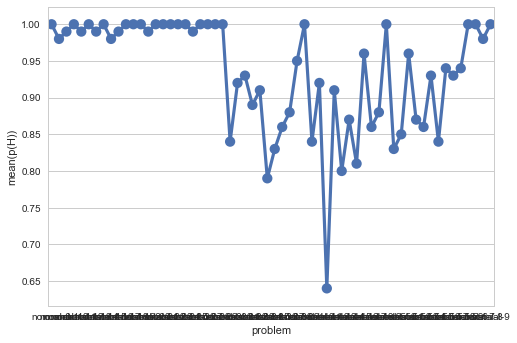

In [1049]:
aggdf = df.groupby(['problem', 'probvar', 'theta']).apply(lambda d: d['p(H)'].mean()).reset_index()
aggdf.columns = ['problem', 'probvar', 'theta', 'p(H)']

sns.pointplot(x='problem', y='p(H)', data=aggdf[aggdf.theta==20])

In [1165]:
pid = 'normal-0'

pars = {'N': 10000,
        'max_T': 1000,
        'probid': pid,
        'tau_normal_trunc': 50,
        'sc': 1,
        'c_sigma': 1,
        'theta': 15}
res = m(problems[pid], pars, trackobs=True)

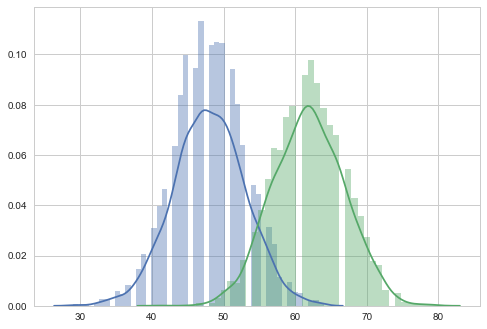

In [1166]:
outcomesA = []
outcomesB = []
for i in range(1000):
    for out in res['outcomes'][i][res['sampled_option'][i]==0]:
        outcomesA.append(out)
    for out in res['outcomes'][i][res['sampled_option'][i]==1]:
        outcomesB.append(out)

sns.distplot(np.array(outcomesA))
sns.distplot(np.array(outcomesB))

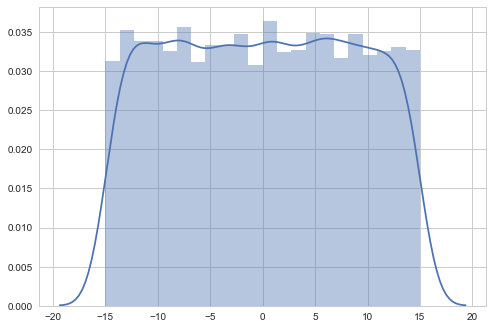

In [1167]:
sns.distplot(res['Z'])

In [1168]:
res['p_resp']

array([ 0.0012,  0.9988])

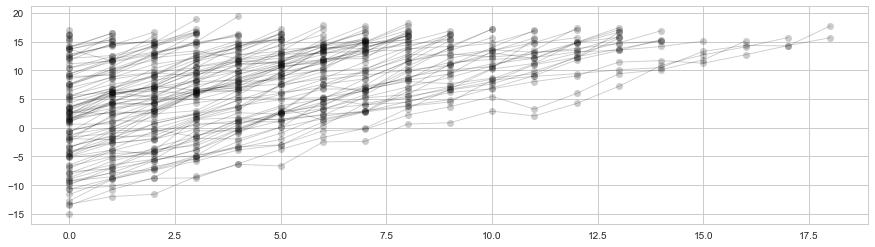

In [1169]:
fig, ax = plt.subplots(figsize=(15,4))
#for i in range(len(results['outcomes'])):
for i in range(100):
    ax.plot(res['traces'][i], '-o',
            color='black', alpha=.2, linewidth=.9)
plt.show()

# Fit

In [1299]:
PARSETS = {}
PARSETS['optional'] = [#['theta', 'theta(cost=high)', 'tau', 'pow_gain'],
                       ['theta(cost=low)', 'theta(cost=high)',
                        'tau_unif(cond_color=same)', 'tau_unif(cond_color=diff)', 'c_sigma']
                       #['theta(cost=low)', 'theta(cost=high)', 'tau(cond_color=same)', 'tau(cond_color=diff)', 'pow_gain'],
                       #['theta', 'p_stay', 'tau', 'tau(cond_color=diff)', 'sc'],
                       #['theta', 'theta(cost=high)', 'p_stay', 'tau', 'sc'],
                       #['theta', 'p_stay', 'tau', 'prelec_gamma'],
                       #['theta', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                       #['theta', 'p_stay', 'tau', 'pow_gain'],
                       #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                       ]

PARSETS['geometric'] = [['p_stop', 'p_stop(cost=high)', 'p_stay', 'tau', 'tau(cond_color=diff)', 'sc'],
                        #['p_stop', 'p_stay', 'tau', 'tau(cond_color=diff)', 'sc'],
                        #['p_stop', 'p_stop(cost=high)', 'p_stay', 'tau', 'sc'],
                        #['p_stop', 'p_stay', 'tau', 'prelec_gamma'],
                        #['p_stop', 'p_stay', 'tau', 'prelec_gamma', 'prelec_elevation'],
                        #['p_stop', 'p_stay', 'tau', 'pow_gain'],
                        #['theta', 'p_stay', 'tau', 'pow_gain', 'w_loss'],
                        ]

FIXED = {}
for pref_units in ['sums', 'diffs']:
    FIXED[('optional',pref_units)] = {'pref_units': pref_units,
                                      'stoprule': 'optional',
                                      'max_T': 1000, 
                                      'N': 10000}

    FIXED[('geometric',pref_units)] = {'pref_units': pref_units,
                                       'stoprule': 'geometric',
                                       'theta': 30}
    
cp = {}
bf_cp = {}
bf_par = {}
msd_cp = {}
quant = {}
bf_quant = {}

cp_asc = {}
bf_cp_asc = {}

N_ITER = 1

In [1300]:
SIM_ID = 'process_markant'
OUTDIR = 'process_fitresults_markant'

F = FIXED[('optional', 'diffs')]

PARSETS = [#['theta(cost=low)', 'theta(cost=high)', 
            #'tau(cond_color=same)', 'tau(cond_color=diff)', 'pow_gain', 'r'],
           ['theta(cost=low)', 'theta(cost=high)',
                        'tau_unif(cond_color=same)', 'tau_unif(cond_color=diff)', 'c_sigma', 'sc2'],
           #['theta(cost=low)', 'theta(cost=high)',
           # 'tau(cond_color=same)', 'tau(cond_color=diff)', 'sc', 'c', 'r']
           ]
m = CHASEProcessModel(problems=problems,
                      problemtype='normal')

In [ ]:
for parset in PARSETS:
    fitting = parset
    results = fit_mlh(m, problems, data, 
                      SIM_ID, F, fitting, ftol=.1, niter=N_ITER, outdir=OUTDIR)

In [292]:
fitting = PARSETS[0]
best = best_result(SIM_ID, F, fitting, outdir=OUTDIR)
print best
pred = predict_from_result(m, problems, data, SIM_ID, F, 
                           fitting = fitting, 
                           outdir=OUTDIR)

index                                                                        0
Unnamed: 0                                                                   0
iteration                                                                    0
success                                                                   True
nllh                                                                    7576.8
k                                                                            5
N                                                                         2400
bic                                                                    15192.5
c_sigma                                                                38.5977
tau_unif(cond_color=diff)                                              106.255
tau_unif(cond_color=same)                                              89.5453
theta(cost=high)                                                        74.369
theta(cost=low)                                     

In [293]:
bf_par[SIM_ID] = best

cp[SIM_ID]       = pred.groupby('problem').apply(lambda d: np.mean(d.choice))
bf_cp[SIM_ID]    = pred.groupby('problem').apply(lambda d: np.mean(d.pred_cp))

quant[SIM_ID]    = mquantiles(data.samplesize)
bf_quant[SIM_ID] = pred[['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].mean().values

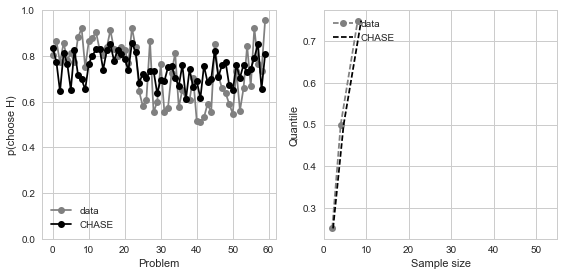

In [294]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
axi = ax[0]
axi.plot(cp[SIM_ID].values, '-o', color='gray', label='data')
axi.plot(bf_cp[SIM_ID].values, '-o', color='black', label='CHASE')
axi.set_ylim(0, 1)
#axi.set_xlim(0, 7)
#axi.set_xticks(range(1,7))
axi.set_xlabel('Problem')
axi.set_ylabel('p(choose H)')
axi.legend()

axi = ax[1]
axi.plot(quant[SIM_ID], [.25, .5, .75], '--o', color='gray', label='data')
axi.plot(bf_quant[SIM_ID], [.25, .5, .75], '--x', color='black', label='CHASE')

axi.set_xlim(0, 55)
axi.legend(loc='upper left')
axi.set_xlabel('Sample size')
axi.set_ylabel('Quantile')

plt.tight_layout()
plt.show()

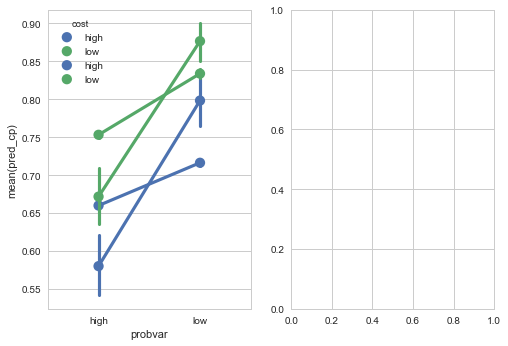

In [295]:
fig, ax = plt.subplots(1, 2)

axi = ax[0]
sns.pointplot(x='probvar', y='choice', hue='cost', data=pred, ax=axi)
sns.pointplot(x='probvar', y='pred_cp', hue='cost', data=pred, ax=axi)

plt.show()

In [296]:
arr = []
for i, grp in pred.groupby(['problem', 'probvar', 'cost']):
    observed = mquantiles(grp.samplesize)
    predicted = grp[['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].mean()
    
    for q, q_obs, q_pred in zip([.25, .5, .75], observed, predicted.values):
        arr.append([grp.problem.values[0],
                    grp.probvar.values[0],
                    grp.cost.values[0],
                    q, q_obs, q_pred])
        
ssdf = pd.DataFrame(arr, columns=['problem', 'probvar', 'cost', 'quantile', 'ss_observed', 'ss_predicted'])

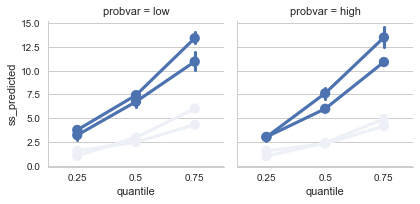

In [297]:
g = sns.FacetGrid(ssdf, col="probvar")
g = g.map(sns.pointplot, "quantile", "ss_observed", "cost")
g = g.map(sns.pointplot, "quantile", "ss_predicted", "cost")

# Individual fits

In [1270]:
from run_markant import *

cp = {}
bf_cp = {}
quant = {}
bf_quant = {}

In [1271]:
results = pd.DataFrame([], columns=['model', 'sim_id', 'sid', 'cond_color', 'stoprule', 'k', 'N', 'nllh', 'bic', 
                                    'tau', 'tau_trunc', 'tau_rel_trunc', 'tau_unif', 'tau_unif_rel', 
                                    'tau_normal', 'tau_normal_trunc',
                                    'theta(cost=low)', 'theta(cost=high)', 
                                    'p_stop_geom(cost=low)', 'p_stop_geom(cost=high)', 'c_sigma',
                                    'sc', 'sc2', 'c', 'c_0', 'pow_gain'])

for sid in data.subject.unique():

    print sid
    cond_color = data.loc[data.subject==sid]['cond_color'].values[0]
    
    for stoprule in ['optional', 'geometric', 'baseline']:
        for i, parset in enumerate(PARSETS[stoprule]):
            b = best(sid, stoprule, parset)
            if b is not None:
                b['model'] = i
                b['sid'] = sid
                b['stoprule'] = stoprule
                b['cond_color'] = cond_color
                results.loc[results.shape[0]] = b
                
results['pars'] = results['sim_id'].apply(lambda d: d.split('|')[0].split('(', 1)[1])

91
92
93
94
96
97
98
99
100
101
102
103
104
105
106
107
109
110
111
112
113
114
115
116
117
119
120
121
123
127
128
129
130
134
135
136
137
138
139
140
141
142
143
144
145
146
148
149
150
151
152
153
154
155
158
159
161
162
163
166
169
170
173
174
175
176
177
178
179
180
181
183
184
186
188
190
191
192
194
195
198
199
200
201
202
203
204
205
206
207
208
209
210
211
213
214
215
216
217
218


In [1251]:
results.sort_values(by=['sid', 'bic'])

,model,sim_id,sid,cond_color,stoprule,k,N,nllh,bic,tau,tau_trunc,tau_rel_trunc,tau_unif,tau_unif_rel,tau_normal,theta(cost=low),theta(cost=high),p_stop_geom(cost=low),p_stop_geom(cost=high),c_sigma,sc,sc2,c,c_0,pow_gain,pars
7,0,"process_baseline_markant_individual_subj91(p_stop_geom|choicerule=random,stoprule=fixedGeom)",91,diff,baseline,1,24,41.557995,86.294044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p_stop_geom
5,0,"process_planned_markant_individual_subj91(c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),s...",91,diff,geometric,5,24,41.027364,97.944998,11.039594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.592827,0.628217,6.399687,1.075439,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),sc,tau"
6,1,"process_planned_markant_individual_subj91(c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),s...",91,diff,geometric,5,24,41.066810,98.023889,23.960262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.627713,0.597681,8.184389,NaN,0.282033,NaN,NaN,NaN,"c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),sc2,tau"
4,4,"process_markant_individual_subj91(c_sigma,sc,tau_normal_trunc,theta(cost=high),theta(cost=low)|N...",91,diff,optional,5,24,41.268621,98.427510,NaN,NaN,NaN,NaN,NaN,NaN,40.095858,44.145533,NaN,NaN,81.634100,1.374127,NaN,NaN,NaN,NaN,"c_sigma,sc,tau_normal_trunc,theta(cost=high),theta(cost=low)"
1,1,"process_markant_individual_subj91(c_sigma,sc2,tau,theta(cost=high),theta(cost=low)|N=10000,max_T...",91,diff,optional,5,24,41.311887,98.514043,3.115555,NaN,NaN,NaN,NaN,NaN,107.555089,126.774433,NaN,NaN,239.335362,NaN,9.264069,NaN,NaN,NaN,"c_sigma,sc2,tau,theta(cost=high),theta(cost=low)"
0,0,"process_markant_individual_subj91(c_sigma,sc,tau,theta(cost=high),theta(cost=low)|N=10000,max_T=...",91,diff,optional,5,24,41.335562,98.561392,16.284556,NaN,NaN,NaN,NaN,NaN,98.284138,92.413001,NaN,NaN,224.415237,0.194398,NaN,NaN,NaN,NaN,"c_sigma,sc,tau,theta(cost=high),theta(cost=low)"
2,2,"process_markant_individual_subj91(c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)|N=10000,...",91,diff,optional,5,24,41.363150,98.616569,NaN,152.481777,NaN,NaN,NaN,NaN,104.923061,84.884624,NaN,NaN,181.290171,1.145923,NaN,NaN,NaN,NaN,"c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)"
3,3,"process_markant_individual_subj91(c_sigma,sc2,tau_trunc,theta(cost=high),theta(cost=low)|N=10000...",91,diff,optional,5,24,41.449474,98.789217,NaN,35.416750,NaN,NaN,NaN,NaN,116.540941,126.533855,NaN,NaN,238.664852,NaN,9.522808,NaN,NaN,NaN,"c_sigma,sc2,tau_trunc,theta(cost=high),theta(cost=low)"
8,0,"process_markant_individual_subj92(c_sigma,sc,tau,theta(cost=high),theta(cost=low)|N=10000,max_T=...",92,same,optional,5,24,66.798874,149.488018,9.447068,NaN,NaN,NaN,NaN,NaN,102.373484,37.875374,NaN,NaN,1.749277,0.111228,NaN,NaN,NaN,NaN,"c_sigma,sc,tau,theta(cost=high),theta(cost=low)"
10,2,"process_markant_individual_subj92(c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)|N=10000,...",92,same,optional,5,24,66.851243,149.592755,NaN,15.905092,NaN,NaN,NaN,NaN,107.606844,37.752600,NaN,NaN,1.502456,0.082736,NaN,NaN,NaN,NaN,"c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)"


In [1272]:
perf = results.groupby(['stoprule', 'model', 'pars']).apply(lambda d: pd.Series({'nllh_sum': d.nllh.sum(),
                                                                                 'bic_sum': d.bic.sum(),
                                                                                 'bic_mn': d.bic.mean()})).reset_index()
perf.sort_values('bic_sum')

,stoprule,model,pars,bic_mn,bic_sum,nllh_sum
7,optional,4,"c_sigma,sc,tau_normal_trunc,theta(cost=high),theta(cost=low)",134.007634,6432.366434,2834.816758
5,optional,2,"c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)",136.511652,13651.165176,6031.069130
3,optional,0,"c_sigma,sc,tau,theta(cost=high),theta(cost=low)",138.372536,13837.253567,6124.113326
4,optional,1,"c_sigma,sc2,tau,theta(cost=high),theta(cost=low)",139.515911,13951.591147,6181.282116
6,optional,3,"c_sigma,sc2,tau_trunc,theta(cost=high),theta(cost=low)",140.140686,14014.068586,6212.520835
2,geometric,1,"c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),sc2,tau",144.685293,14468.529294,6439.751189
1,geometric,0,"c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),sc,tau",144.706624,14470.662356,6440.817720
0,baseline,0,p_stop_geom,152.006893,15200.689323,7441.441970


In [1350]:
results[results.sid==214]

,model,sim_id,sid,cond_color,stoprule,k,N,nllh,bic,tau,tau_trunc,tau_rel_trunc,tau_unif,tau_unif_rel,tau_normal,tau_normal_trunc,theta(cost=low),theta(cost=high),p_stop_geom(cost=low),p_stop_geom(cost=high),c_sigma,sc,sc2,c,c_0,pow_gain,pars
713,0,"process_markant_individual_subj214(c_sigma,sc,tau,theta(cost=high),theta(cost=low)|N=10000,max_T...",214,same,optional,5,24,66.275706,148.441681,35.425920,NaN,NaN,NaN,NaN,NaN,NaN,509.655036,140.118575,NaN,NaN,203.321948,0.103107,NaN,NaN,NaN,NaN,"c_sigma,sc,tau,theta(cost=high),theta(cost=low)"
714,1,"process_markant_individual_subj214(c_sigma,sc2,tau,theta(cost=high),theta(cost=low)|N=10000,max_...",214,same,optional,5,24,63.128512,142.147292,105.343149,NaN,NaN,NaN,NaN,NaN,NaN,1392.454095,414.801564,NaN,NaN,541.917347,NaN,0.015045,NaN,NaN,NaN,"c_sigma,sc2,tau,theta(cost=high),theta(cost=low)"
715,2,"process_markant_individual_subj214(c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)|N=10000...",214,same,optional,5,24,62.223225,140.336719,NaN,91.160336,NaN,NaN,NaN,NaN,NaN,48.717593,11.896002,NaN,NaN,9.204474,0.175931,NaN,NaN,NaN,NaN,"c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)"
716,3,"process_markant_individual_subj214(c_sigma,sc2,tau_trunc,theta(cost=high),theta(cost=low)|N=1000...",214,same,optional,5,24,61.950421,139.791111,NaN,110.599663,NaN,NaN,NaN,NaN,NaN,269.100912,69.868872,NaN,NaN,93.256526,NaN,0.043857,NaN,NaN,NaN,"c_sigma,sc2,tau_trunc,theta(cost=high),theta(cost=low)"
717,0,"process_planned_markant_individual_subj214(c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),...",214,same,geometric,5,24,63.213298,142.316865,14.051722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116571,0.464824,7.192837,0.266570,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),sc,tau"
718,1,"process_planned_markant_individual_subj214(c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),...",214,same,geometric,5,24,62.616586,141.123441,112.240869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.131026,0.529868,33.619529,NaN,0.052846,NaN,NaN,NaN,"c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),sc2,tau"
719,0,"process_baseline_markant_individual_subj214(p_stop_geom|choicerule=random,stoprule=fixedGeom)",214,same,baseline,1,24,75.984231,155.146516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p_stop_geom


In [1353]:
data.subject.unique()

array([ 91,  92,  93,  94,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119,
       120, 121, 123, 127, 128, 129, 130, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153,
       154, 155, 158, 159, 161, 162, 163, 166, 169, 170, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 183, 184, 186, 188, 190, 191, 192,
       194, 195, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 213, 214, 215, 216, 217, 218])

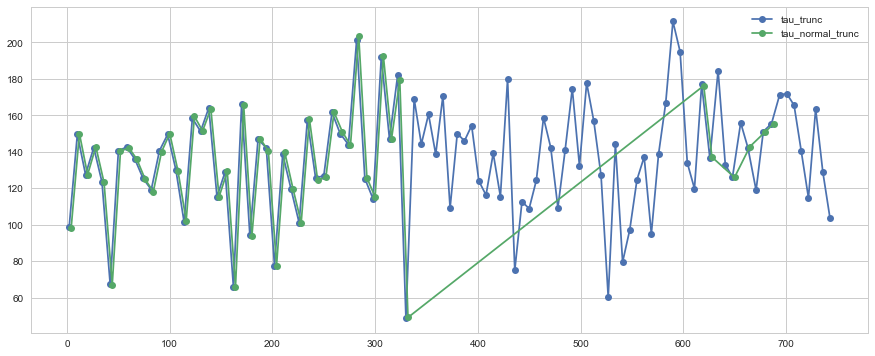

In [1273]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(results[(results.model==2) & (results.stoprule=='optional')].bic, '-o', label='tau_trunc')
ax.plot(results[(results.model==4) & (results.stoprule=='optional')].bic, '-o', label='tau_normal_trunc')
#ax.plot(results[(results.model==2) & (results.stoprule=='optional')].bic, '-o')
ax.legend()
plt.show()

In [1242]:
results[results.sid==201].sort_values(by='bic')

,model,sim_id,sid,cond_color,stoprule,k,N,nllh,bic,tau,tau_trunc,tau_rel_trunc,tau_unif,tau_unif_rel,tau_normal,theta(cost=low),theta(cost=high),p_stop_geom(cost=low),p_stop_geom(cost=high),c_sigma,sc,sc2,c,c_0,pow_gain,pars
583,2,"process_markant_individual_subj201(c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)|N=10000...",201,diff,optional,5,24,60.299875,136.490019,NaN,0.245451,NaN,NaN,NaN,NaN,89.128052,25.649356,NaN,NaN,6.452745,0.087241,NaN,NaN,NaN,NaN,"c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)"
581,0,"process_markant_individual_subj201(c_sigma,sc,tau,theta(cost=high),theta(cost=low)|N=10000,max_T...",201,diff,optional,5,24,60.586478,137.063225,1.584764,NaN,NaN,NaN,NaN,NaN,85.898749,28.402430,NaN,NaN,7.341898,0.067599,NaN,NaN,NaN,NaN,"c_sigma,sc,tau,theta(cost=high),theta(cost=low)"
584,3,"process_markant_individual_subj201(c_sigma,sc2,tau_trunc,theta(cost=high),theta(cost=low)|N=1000...",201,diff,optional,5,24,66.428272,148.746814,NaN,2.091605,NaN,NaN,NaN,NaN,280.946488,89.503997,NaN,NaN,61.769258,NaN,0.059947,NaN,NaN,NaN,"c_sigma,sc2,tau_trunc,theta(cost=high),theta(cost=low)"
582,1,"process_markant_individual_subj201(c_sigma,sc2,tau,theta(cost=high),theta(cost=low)|N=10000,max_...",201,diff,optional,5,24,66.473361,148.836992,12.964317,NaN,NaN,NaN,NaN,NaN,1307.289744,431.304217,NaN,NaN,278.597104,NaN,0.017866,NaN,NaN,NaN,"c_sigma,sc2,tau,theta(cost=high),theta(cost=low)"
586,1,"process_planned_markant_individual_subj201(c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),...",201,diff,geometric,5,24,70.353885,156.598039,10.172566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.087314,0.303199,99.555232,NaN,0.013261,NaN,NaN,NaN,"c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),sc2,tau"
585,0,"process_planned_markant_individual_subj201(c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),...",201,diff,geometric,5,24,70.533443,156.957154,8.512815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.086231,0.290985,3.004276,0.424359,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),sc,tau"
587,0,"process_baseline_markant_individual_subj201(p_stop_geom|choicerule=random,stoprule=fixedGeom)",201,diff,baseline,1,24,85.742409,174.662871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p_stop_geom


In [1257]:
sel = results[(results.model==4)]

In [268]:
sel = results[(results.model==3) & (results.stoprule=='optional')]

In [ ]:
sel = results[((results.model==2) & (results.stoprule=='optional')) | 
              ((results.model==0) & (results.stoprule=='geometric')) | 
              (results.stoprule=='baseline')]

In [1258]:
optional = sel[sel.stoprule=='optional']
planned = sel[sel.stoprule=='geometric']
print optional.shape
print planned.shape

(44, 27)
(0, 27)


In [1089]:
bestmodel = sel.sort_values(by=['sid', 'bic']).groupby('sid').apply(lambda d: d.stoprule.values[0])
n_opt = np.sum(bestmodel=='optional')
n_geom = np.sum(bestmodel=='geometric')
n_base = np.sum(bestmodel=='baseline')
n_total = bestmodel.shape[0]
print 'optional:\t%s/%s (%s)' % (n_opt, n_total, np.round(n_opt/float(n_total), 2))
print 'geometric:\t%s/%s (%s)' % (n_geom, n_total, np.round(n_geom/float(n_total), 2))
print 'baseline:\t%s/%s (%s)' % (n_base, n_total, np.round(n_base/float(n_total), 2))
optional_sset = bestmodel[bestmodel=='optional'].index
best_optional = optional[optional.sid.isin(optional_sset)]

optional:	77/100 (0.77)
geometric:	4/100 (0.04)
baseline:	19/100 (0.19)


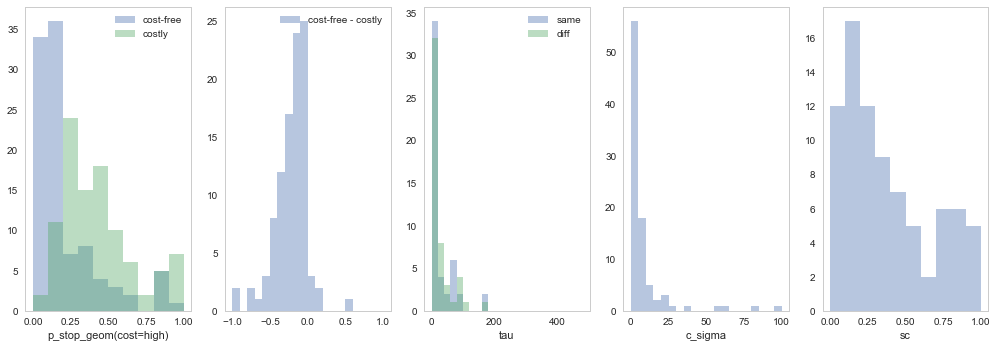

In [171]:
fig, ax = plt.subplots(1, 5, figsize=(14,5))

axi = ax[0]
sns.distplot(planned['p_stop_geom(cost=low)'], 
             kde=False, bins=np.arange(0, 1.1, .1), ax=axi, label='cost-free')
sns.distplot(planned['p_stop_geom(cost=high)'], 
             kde=False, bins=np.arange(0, 1.1, .1), ax=axi, label='costly')
axi.legend()

axi = ax[1]
sns.distplot(planned['p_stop_geom(cost=low)'] - planned['p_stop_geom(cost=high)'], 
             kde=False, bins=np.arange(-1, 1.1, .1), ax=axi, label='cost-free - costly')
axi.legend()

axi = ax[2]
sns.distplot(planned[planned.cond_color=='same']['tau'], 
             kde=False, bins=range(0, 500, 20), ax=axi, label='same')
sns.distplot(planned[planned.cond_color=='diff']['tau'], 
             kde=False, bins=range(0, 500, 20), ax=axi, label='diff')
axi.legend()

axi = ax[3]
sns.distplot(planned['c_sigma'], kde=False, bins=range(0, 105, 5), ax=axi)

axi = ax[4]
sns.distplot(planned['sc'], kde=False, bins=np.arange(0, 1.1, .1), ax=axi)




for axi in ax:
    axi.grid(False)

plt.tight_layout()
plt.show()

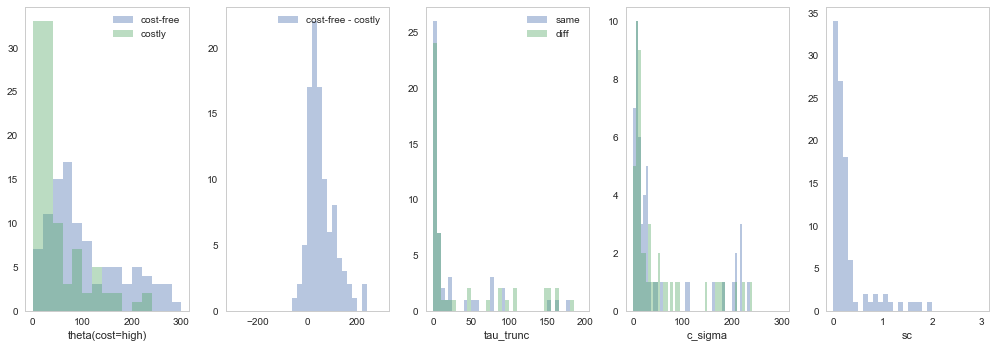

In [1092]:
fig, ax = plt.subplots(1, 5, figsize=(14,5))

axi = ax[0]
sns.distplot(optional['theta(cost=low)'], 
             kde=False, bins=range(0, 320, 20), ax=axi, label='cost-free')
sns.distplot(optional['theta(cost=high)'], 
             kde=False, bins=range(0, 320, 20), ax=axi, label='costly')
axi.legend()

axi = ax[1]
sns.distplot(optional['theta(cost=low)'] - optional['theta(cost=high)'],
             kde=False, bins=range(-300, 320, 20), ax=axi, label='cost-free - costly')
axi.legend()

axi = ax[2]
sns.distplot(optional[optional.cond_color=='same']['tau_trunc'], 
             kde=False, bins=range(0, 200, 5), ax=axi, label='same')
sns.distplot(optional[optional.cond_color=='diff']['tau_trunc'], 
             kde=False, bins=range(0, 200, 5), ax=axi, label='diff')
axi.legend()

axi = ax[3]
sns.distplot(optional[optional.cond_color=='same']['c_sigma'], 
             kde=False, bins=range(0, 305, 5), ax=axi, label='same')
sns.distplot(optional[optional.cond_color=='diff']['c_sigma'], 
             kde=False, bins=range(0, 305, 5), ax=axi, label='diff')

axi = ax[4]
sns.distplot(optional['sc'], kde=False, bins=np.arange(0, 3.1, .1), ax=axi)


for axi in ax:
    axi.grid(False)

plt.tight_layout()
plt.show()

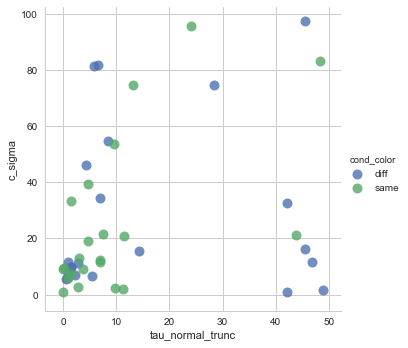

In [1260]:
sns.lmplot('tau_normal_trunc', 'c_sigma',
           data=optional,
           fit_reg=False,
           hue="cond_color",  
           scatter_kws={"marker": "D",
                        "s": 100})

In [1261]:
data.subject.unique()

array([ 91,  92,  93,  94,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 119,
       120, 121, 123, 127, 128, 129, 130, 134, 135, 136, 137, 138, 139,
       140, 141, 142, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153,
       154, 155, 158, 159, 161, 162, 163, 166, 169, 170, 173, 174, 175,
       176, 177, 178, 179, 180, 181, 183, 184, 186, 188, 190, 191, 192,
       194, 195, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208,
       209, 210, 211, 213, 214, 215, 216, 217, 218])

In [605]:
optional[optional.c_sigma > 100]

,model,sim_id,sid,cond_color,stoprule,k,N,nllh,bic,tau,tau_rel_trunc,tau_unif,tau_unif_rel,tau_normal,theta(cost=low),theta(cost=high),p_stop_geom(cost=low),p_stop_geom(cost=high),sc,sc2,r,c,c_sigma,c_0,pow_gain,pars
0,0,"process_markant_individual_subj91(c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)|N=10...",91,diff,optional,5,24,41.334656,98.559581,NaN,37.673929,NaN,NaN,NaN,110.992180,122.708986,NaN,NaN,0.036394,NaN,NaN,NaN,229.757913,NaN,NaN,"c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)"
8,0,"process_markant_individual_subj96(c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)|N=10...",96,same,optional,5,24,53.628549,123.147367,NaN,47.233041,NaN,NaN,NaN,131.730305,153.170817,NaN,NaN,1.079830,NaN,NaN,NaN,160.448206,NaN,NaN,"c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)"
10,0,"process_markant_individual_subj97(c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)|N=10...",97,same,optional,5,24,25.666166,67.222601,NaN,93.788805,NaN,NaN,NaN,40.195156,16.110580,NaN,NaN,0.225519,NaN,NaN,NaN,230.333876,NaN,NaN,"c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)"
20,0,"process_markant_individual_subj102(c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)|N=1...",102,same,optional,5,24,52.536221,120.962711,NaN,0.014695,NaN,NaN,NaN,156.853147,124.685010,NaN,NaN,1.802758,NaN,NaN,NaN,188.671894,NaN,NaN,"c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)"
26,0,"process_markant_individual_subj105(c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)|N=1...",105,diff,optional,5,24,57.608208,131.106685,NaN,72.273159,NaN,NaN,NaN,281.715930,111.120927,NaN,NaN,1.827467,NaN,NaN,NaN,185.578737,NaN,NaN,"c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)"
28,0,"process_markant_individual_subj106(c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)|N=1...",106,same,optional,5,24,44.859142,105.608553,NaN,46.983022,NaN,NaN,NaN,182.903241,36.453099,NaN,NaN,0.074284,NaN,NaN,NaN,147.536264,NaN,NaN,"c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)"
36,0,"process_markant_individual_subj111(c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)|N=1...",111,diff,optional,5,24,49.796401,115.483072,NaN,11.833839,NaN,NaN,NaN,227.625395,82.277835,NaN,NaN,0.854299,NaN,NaN,NaN,189.259987,NaN,NaN,"c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)"
40,0,"process_markant_individual_subj113(c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)|N=1...",113,same,optional,5,24,24.971052,65.832374,NaN,68.650446,NaN,NaN,NaN,56.106978,0.139036,NaN,NaN,1.449292,NaN,NaN,NaN,184.649561,NaN,NaN,"c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)"
44,0,"process_markant_individual_subj115(c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)|N=1...",115,diff,optional,5,24,39.186768,94.263806,NaN,18.660811,NaN,NaN,NaN,94.685394,74.563209,NaN,NaN,1.486387,NaN,NaN,NaN,204.303682,NaN,NaN,"c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)"
56,0,"process_markant_individual_subj123(c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)|N=1...",123,same,optional,5,24,42.642725,101.175719,NaN,31.733384,NaN,NaN,NaN,71.830371,151.282726,NaN,NaN,1.397669,NaN,NaN,NaN,189.237964,NaN,NaN,"c_sigma,sc,tau_rel_trunc,theta(cost=high),theta(cost=low)"


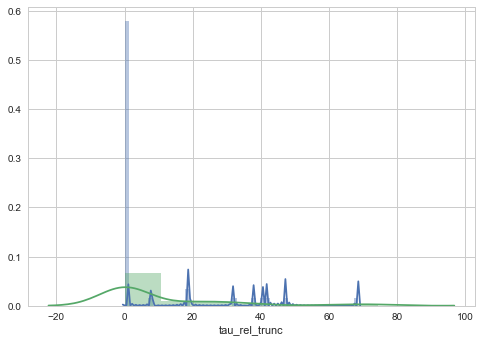

In [607]:
sns.distplot(best_optional[best_optional.cond_color=='same']['tau_rel_trunc'])
sns.distplot(best_optional[best_optional.cond_color=='diff']['tau_rel_trunc'])

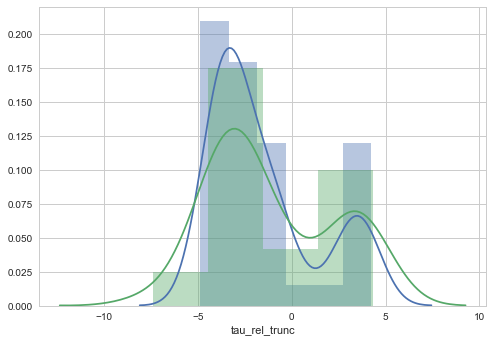

In [608]:
sns.distplot(np.log(best_optional[best_optional.cond_color=='same']['tau_rel_trunc']))
sns.distplot(np.log(best_optional[best_optional.cond_color=='diff']['tau_rel_trunc']))

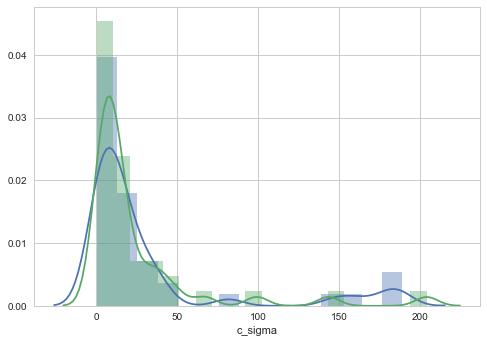

In [609]:
sns.distplot(best_optional[best_optional.cond_color=='same']['c_sigma'])
sns.distplot(best_optional[best_optional.cond_color=='diff']['c_sigma'])

In [1098]:
arr_theta = np.array([best_optional['theta(cost=low)'],
                      best_optional['theta(cost=high)'],
                      best_optional['theta(cost=low)'] - best_optional['theta(cost=high)']]).transpose()

arr_tau   = np.array([best_optional[best_optional.cond_color=='same']['tau_trunc'],
                      best_optional[best_optional.cond_color=='diff']['tau_trunc']]).transpose()

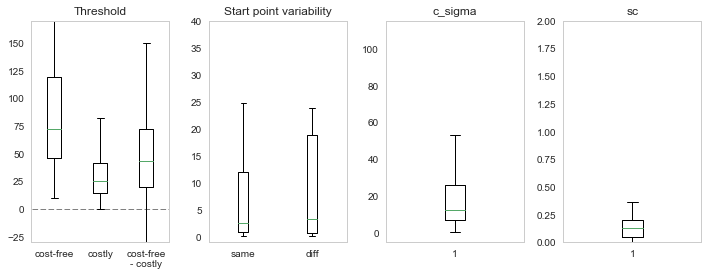

In [1101]:
fig, ax = plt.subplots(1, 4, figsize=(10,4))



axi = ax[0]
axi.plot([0, 4], [0, 0], '--', color='gray', linewidth=1)
#axi.violinplot(arr_theta, showmedians=True, showextrema=False)
axi.boxplot(arr_theta)
axi.set_xlim(.5,3.5)
axi.set_ylim(-30, 170)
axi.set_title('Threshold')
axi.set_xticklabels(['cost-free', 'costly', 'cost-free\n- costly'])


axi = ax[1]
axi.boxplot(arr_tau)
axi.set_title('Start point variability')
axi.set_ylim(-1, 40)
axi.set_xticklabels(['same', 'diff'])

axi = ax[2]
axi.boxplot(best_optional['c_sigma'].values)
axi.set_title('c_sigma')

axi = ax[3]
axi.boxplot(best_optional['sc'].values)
axi.set_title('sc')
axi.set_ylim(0,2)

for axi in ax:
    axi.grid(False)

plt.tight_layout()
plt.show()

In [1104]:
print np.median(best_optional['theta(cost=low)'].values)
print np.median(best_optional['theta(cost=high)'].values)
print np.median(best_optional['c_sigma'].values)
print np.median(best_optional['sc'].values)

72.374235823
25.6493555845
12.1831288814
0.129478365077


In [1105]:
print np.mean(best_optional[best_optional.cond_color=='same']['tau_trunc'])
print np.mean(best_optional[best_optional.cond_color=='diff']['tau_trunc'])
print np.median(best_optional[best_optional.cond_color=='same']['tau_trunc'])
print np.median(best_optional[best_optional.cond_color=='diff']['tau_trunc'])

18.7431197191
26.0519473331
2.64914610625
3.35475807964


In [1107]:
ttest_ind(best_optional[(best_optional.cond_color=='same')]['tau_trunc'].values,
          best_optional[(best_optional.cond_color=='diff')]['tau_trunc'].values)

Ttest_indResult(statistic=-0.76492718151153838, pvalue=0.44671517654644866)

In [1001]:
ttest_ind(optional[(optional.cond_color=='same') & (optional.sid.isin(optional_sset))]['tau_trunc'].values,
          optional[(optional.cond_color=='diff') & (optional.sid.isin(optional_sset))]['tau_trunc'].values)

Ttest_indResult(statistic=-0.42218497788551035, pvalue=0.67398161422282321)

In [1002]:
from scipy.stats import mannwhitneyu
mannwhitneyu(optional[(optional.cond_color=='same') & (optional.sid.isin(optional_sset))]['tau_trunc'].values,
             optional[(optional.cond_color=='diff') & (optional.sid.isin(optional_sset))]['tau_trunc'].values)

MannwhitneyuResult(statistic=870.0, pvalue=0.3975348611327556)

## Check predictions

In [1328]:
SSET = sel.sid.drop_duplicates()
SSET = data.subject.unique()

pset = {'optional': ['theta(cost=low)', 'theta(cost=high)', 'tau_normal_trunc', 
                     'c_sigma', 'sc_x(probvar=low)', 'sc_x(probvar=high)'],
        'geometric': ['p_stop_geom(cost=low)', 'p_stop_geom(cost=high)', 'tau', 'c_sigma', 'sc']}

In [1329]:
# generate predictions for each subject
pred = {}
bfpars = {}

#for sid in SSET:
for sid in [217]:

    sid = int(sid)
    print sid
    sdata = data[data.subject==sid]
    
    #for stoprule in ['optional', 'geometric']:
    for stoprule in ['optional']:
        bfpars[(sid,stoprule)] = best(sid, stoprule, pset[stoprule])          
        pred[(sid,stoprule)] = predict(sid, sdata, problems, stoprule, pset[stoprule])          

217


In [1330]:
df = pd.DataFrame([], columns=['subject', 'stoprule', 'probvar', 'cost', 'choseH', 'pred_cp', 
                               'ss(.25)', 'ss(.5)', 'ss(.75)',
                               'pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)'])


#for sid in SSET:
for sid in [217]:

    #for stoprule in ['optional', 'geometric']:
    for stoprule in ['optional']:

        grp = pred[(sid,stoprule)].groupby(['subject', 'cond_color', 'probvar', 'cost'])
        
        agg = grp.apply(lambda d: pd.Series({'choseH': d.choseH.mean(),
                                             'pred_cp': d.pred_cp.mean(),
                                             'ss(.25)': mquantiles(d.samplesize.values)[0],
                                             'ss(.5)': mquantiles(d.samplesize.values)[1],
                                             'ss(.75)': mquantiles(d.samplesize.values)[2],
                                             'pred_ss(.25)': d['pred_ss(.25)'].mean(),
                                             'pred_ss(.5)': d['pred_ss(.5)'].mean(),
                                             'pred_ss(.75)': d['pred_ss(.75)'].mean(),
                                             'pred_ss_L(.25)': np.nanmean(d['pred_ss_L(.25)']),
                                             'pred_ss_L(.5)': np.nanmean(d['pred_ss_L(.5)']),
                                             'pred_ss_L(.75)': np.nanmean(d['pred_ss_L(.75)']),
                                             'pred_ss_H(.25)': np.nanmean(d['pred_ss_H(.25)']),
                                             'pred_ss_H(.5)': np.nanmean(d['pred_ss_H(.5)']),
                                             'pred_ss_H(.75)': np.nanmean(d['pred_ss_H(.75)'])})).reset_index()
        
        agg['stoprule'] = stoprule
            
        df = pd.concat((df, agg))

In [1331]:
stoprule = 'optional'
sdf = df[df.stoprule==stoprule]

# exclude subjects best-fit by geometric model
sdf = sdf[sdf['subject'].apply(lambda d: d in optional_sset).values]

grouped = sdf.groupby(['probvar', 'cost']).agg([np.mean, sem])

In [1112]:
grouped

choseH             pred_cp           pred_ss(.25)            \
                  mean       sem      mean       sem         mean       sem   
probvar cost                                                                  
high    high  0.612554  0.020997  0.654030  0.008364     1.816775  0.193878   
        low   0.720779  0.021222  0.756639  0.010850     4.875000  0.445969   
low     high  0.859307  0.022018  0.865541  0.016607     2.537771  0.261442   
        low   0.943723  0.014323  0.928589  0.013037     6.663312  0.451421   

             pred_ss(.5)           pred_ss(.75)           pred_ss_H(.25)  \
                    mean       sem         mean       sem           mean   
probvar cost                                                               
high    high    2.886364  0.336613     4.805628  0.562772       1.822511   
        low     8.461039  0.775274    14.316775  1.312013       4.924459   
low     high    3.807359  0.393200     5.869805  0.620092       2.552273   
        low     9.785714  0.627849    14.452489  0.941230       6.707576   

                       pred_ss_H(.5)           pred_ss_H(.75)            \
                   sem          mean       sem           mean       sem   
probvar cost                                                              
high    high  0.194242      2.915584  0.335899       4.804545  0.560874   
        low   0.446955      8.512987  0.771935      14.399242  1.312784   
low     high  0.259928      3.818182  0.392255       5.882251  0.619289   
        low   0.449307      9.829004  0.628923      14.491342  0.942801   

             pred_ss_L(.25)           pred_ss_L(.5)           pred_ss_L(.75)  \
                       mean       sem          mean       sem           mean   
probvar cost                                                                   
high    high       1.803030  0.201982      2.876623  0.349464       4.792532   
        low        4.655519  0.448008      8.108225  0.777332      13.932684   
low     high       2.760124       NaN      3.948761       NaN       6.012680   
        low        7.306389       NaN     10.723232       NaN      16.282386   

                         ss(.25)               ss(.5)              ss(.75)  \
                   sem      mean       sem       mean       sem       mean   
probvar cost                                                                 
high    high  0.576682  2.868831  0.303674   3.474026  0.341994   4.301948   
        low   1.303604  8.090260  0.633463  10.487013  0.787428  14.454545   
low     high       NaN  3.047403  0.313010   3.487013  0.332503   4.405195   
        low        NaN  6.966234  0.499974   8.824675  0.574415  11.264935   

                        
                   sem  
probvar cost            
high    high  0.399313  
        low   1.062860  
low     high  0.435794  
        low   0.734083

In [1009]:
from mypy.viz import tableau20
cols = [tableau20[0], tableau20[8], tableau20[4], tableau20[16]]

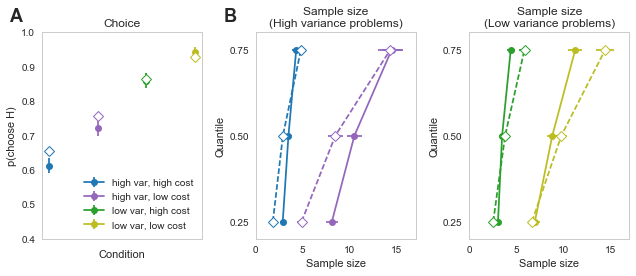

In [1113]:
fig, ax = plt.subplots(1, 3, figsize=(9,4))

xs = [1, 2, 3, 4]
axi = ax[0]

axi.errorbar([1], grouped.loc['high','high']['choseH']['mean'],
             yerr=grouped.loc['high','high']['choseH']['sem'],
             marker='o',
             color=cols[0], label='high var, high cost')

axi.errorbar([2], grouped.loc['high','low']['choseH']['mean'],
             yerr=grouped.loc['high','low']['choseH']['sem'],
             marker='o',
             color=cols[1], label='high var, low cost')

axi.errorbar([3], grouped.loc['low','high']['choseH']['mean'],
             yerr=grouped.loc['low','high']['choseH']['sem'],
             marker='o',
             color=cols[2], label='low var, high cost')

axi.errorbar([4], grouped.loc['low','low']['choseH']['mean'],
             yerr=grouped.loc['low','low']['choseH']['sem'],
             marker='o',
             color=cols[3], label='low var, low cost')


axi.errorbar([1], grouped.loc['high','high']['pred_cp']['mean'],
             yerr=grouped.loc['high','high']['pred_cp']['sem'],
             marker='D', markeredgewidth=1, markerfacecolor='white', linestyle='--',
             color=cols[0])

axi.errorbar([2], grouped.loc['high','low']['pred_cp']['mean'],
             yerr=grouped.loc['high','low']['pred_cp']['sem'],
             marker='D', markeredgewidth=1, markerfacecolor='white', linestyle='--',
             color=cols[1])

axi.errorbar([3], grouped.loc['low','high']['pred_cp']['mean'],
             yerr=grouped.loc['low','high']['pred_cp']['sem'],
             marker='D', markeredgewidth=1, markerfacecolor='white', linestyle='--',
             color=cols[2])

axi.errorbar([4], grouped.loc['low','low']['pred_cp']['mean'],
             yerr=grouped.loc['low','low']['pred_cp']['sem'],
             marker='D', markeredgewidth=1, markerfacecolor='white', linestyle='--',
             color=cols[3])


axi.set_title('Choice')
axi.set_ylabel('p(choose H)')
axi.set_ylim(.4, 1)
axi.set_xlabel('Condition')
axi.set_xticks(xs)
axi.set_xticklabels([''])
axi.legend(loc='lower right')
axi.text(-.2, 1.05, 'A', fontsize=18, fontweight='semibold', transform=axi.transAxes)

qs = [.25, .5, .75]
axi = ax[1]
axi.errorbar(grouped.loc['high','high'][['ss(.25)', 'ss(.5)', 'ss(.75)']].loc[:,'mean'].values, qs,
             xerr=grouped.loc['high','high'][['ss(.25)', 'ss(.5)', 'ss(.75)']].loc[:,'sem'].values,
             marker='o',
             color=cols[0], label='data')

axi.errorbar(grouped.loc['high','low'][['ss(.25)', 'ss(.5)', 'ss(.75)']].loc[:,'mean'].values, qs,
             xerr=grouped.loc['high','low'][['ss(.25)', 'ss(.5)', 'ss(.75)']].loc[:,'sem'].values,
             marker='o',
             color=cols[1], label='data')

axi.errorbar(grouped.loc['high','high'][['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].loc[:,'mean'].values, qs,
             xerr=grouped.loc['high','high'][['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].loc[:,'sem'].values,
             marker='D', markeredgewidth=1, markerfacecolor='white', linestyle='--',
             color=cols[0], label='data')

axi.errorbar(grouped.loc['high','low'][['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].loc[:,'mean'].values, qs,
             xerr=grouped.loc['high','low'][['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].loc[:,'sem'].values,
             marker='D', markeredgewidth=1, markerfacecolor='white', linestyle='--',
             color=cols[1], label='data')
axi.set_xlim(0,17)
axi.set_ylim(.2,.8)
axi.set_yticks(qs)
axi.set_ylabel('Quantile')
axi.set_xlabel('Sample size')
axi.set_title('Sample size\n(High variance problems)')
axi.text(-.2, 1.05, 'B', fontsize=18, fontweight='semibold', transform=axi.transAxes)

axi = ax[2]
axi.errorbar(grouped.loc['low','high'][['ss(.25)', 'ss(.5)', 'ss(.75)']].loc[:,'mean'].values, qs,
             xerr=grouped.loc['low','high'][['ss(.25)', 'ss(.5)', 'ss(.75)']].loc[:,'sem'].values,
             marker='o',
             color=cols[2], label='data')

axi.errorbar(grouped.loc['low','low'][['ss(.25)', 'ss(.5)', 'ss(.75)']].loc[:,'mean'].values, qs,
             xerr=grouped.loc['low','low'][['ss(.25)', 'ss(.5)', 'ss(.75)']].loc[:,'sem'].values,
             marker='o',
             color=cols[3], label='data')

axi.errorbar(grouped.loc['low','high'][['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].loc[:,'mean'].values, qs,
             xerr=grouped.loc['low','high'][['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].loc[:,'sem'].values,
             marker='D', markeredgewidth=1, markerfacecolor='white', linestyle='--',
             color=cols[2], label='data')

axi.errorbar(grouped.loc['low','low'][['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].loc[:,'mean'].values, qs,
             xerr=grouped.loc['low','low'][['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']].loc[:,'sem'].values,
             marker='D', markeredgewidth=1, markerfacecolor='white', linestyle='--',
             color=cols[3], label='data')
axi.set_ylim(.2,.8)
axi.set_xlim(0,17)
axi.set_yticks(qs)
axi.set_ylabel('Quantile')
axi.set_xlabel('Sample size')
axi.set_title('Sample size\n(Low variance problems)')




for axi in ax:
    axi.grid(False)

plt.tight_layout()
plt.show()
#fig.savefig('%s/fitresults_markant.pdf' % FIGDEST, bbox_inches='tight')

In [1114]:
df = pd.DataFrame([], columns=['problem', 'stoprule', 'probvar', 'cost', 'choseH', 'pred_cp', 
                               'ss(.25)', 'ss(.5)', 'ss(.75)',
                               'pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)'])

for sid in SSET:
#for sid in optional_sset:

    sid = int(sid)
    sdata = data[data.subject==sid]
    
    #for stoprule in ['optional', 'geometric']:
    for stoprule in ['optional']:

        grp = pred[(sid,stoprule)].groupby(['problem', 'cond_color', 'probvar', 'cost'])
        
        obs = grp.apply(lambda d: d.choseH.mean()).reset_index()
        obs.columns = ['problem', 'cond_color', 'probvar', 'cost', 'choseH']
        
        obs['pred_cp']   = grp.apply(lambda d: d.pred_cp.mean()).values    

        obs['ss(.25)'] = grp.apply(lambda d: mquantiles(d.samplesize.values)[0]).values
        obs['ss(.5)']  = grp.apply(lambda d: mquantiles(d.samplesize.values)[1]).values
        obs['ss(.75)'] = grp.apply(lambda d: mquantiles(d.samplesize.values)[2]).values

        obs['pred_ss(.25)'] = grp.apply(lambda d: d['pred_ss(.25)'].mean()).values
        obs['pred_ss(.5)']  = grp.apply(lambda d: d['pred_ss(.5)'].mean()).values
        obs['pred_ss(.75)'] = grp.apply(lambda d: d['pred_ss(.75)'].mean()).values

        obs['pred_ss_L(.25)'] = grp.apply(lambda d: np.nanmean(d['pred_ss_L(.25)'])).values
        obs['pred_ss_L(.5)']  = grp.apply(lambda d: np.nanmean(d['pred_ss_L(.5)'])).values
        obs['pred_ss_L(.75)'] = grp.apply(lambda d: np.nanmean(d['pred_ss_L(.75)'])).values

        obs['pred_ss_H(.25)'] = grp.apply(lambda d: np.nanmean(d['pred_ss_H(.25)'])).values
        obs['pred_ss_H(.5)']  = grp.apply(lambda d: np.nanmean(d['pred_ss_H(.5)'])).values
        obs['pred_ss_H(.75)'] = grp.apply(lambda d: np.nanmean(d['pred_ss_H(.75)'])).values

        obs['stoprule'] = stoprule
    
        df = pd.concat((df, obs))

def nansem(x): 
    return np.std(x, ddof=1)/np.sqrt(x.count())

grouped = df.groupby(['probvar', 'cost']).agg([np.nanmean, nansem])

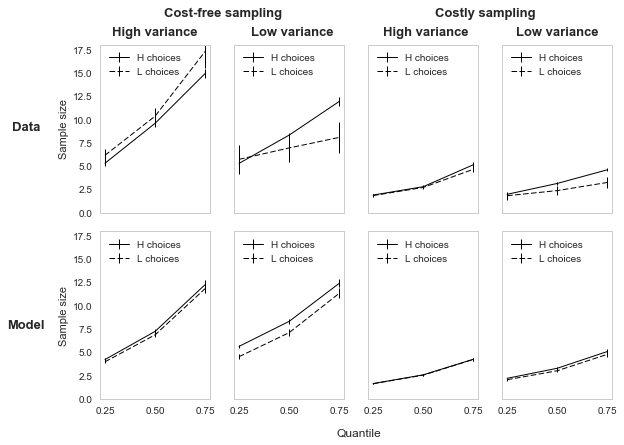

In [1115]:
styl = ['--', '-']

fig, ax = plt.subplots(2, 4, sharey=True, sharex=True)

for j, cost in enumerate(['low', 'high']):
    for k, probvar in enumerate(['high', 'low']):

        # data
        axi = ax[0][2*j + k]
        for choseH in [1, 0]:

            cdf = data[(data.subject.isin(optional_sset)) & (data.probvar==probvar) & (data.cost==cost) & (data.choseH==choseH)]

            q = np.array(map(lambda x: np.array(x), cdf.groupby('problem').apply(lambda d: mquantiles(d.samplesize)).values))
            q_obs = q.mean(axis=0)
            q_se  = q.std(axis=0)/np.sqrt(q.shape[0])

            axi.errorbar(qs, q_obs, yerr=q_se, 
                         fmt=styl[choseH], color='black', linewidth=1,
                         label=['L choices', 'H choices'][choseH])


            #axi.plot(qs, mquantiles(cdf.samplesize), styl[choseH], color='black',
            #         marker='o', markerfacecolor='white', markeredgewidth=1, linewidth=1)

            axi.legend(loc='upper left')
            axi.grid(False)
            axi.set_xticks(qs)
            axi.set_ylim(0, 18)

        # model
        axi = ax[1][2*j + k]
        for choseH in [1, 0]:

            if choseH == 0:
                columns = ['pred_ss_L(.25)', 'pred_ss_L(.5)', 'pred_ss_L(.75)']
            else:
                columns = ['pred_ss_H(.25)', 'pred_ss_H(.5)', 'pred_ss_H(.75)']
            
            axi.errorbar(qs, grouped.loc[probvar,cost][columns].loc[:,'nanmean'].values,
                         yerr=grouped.loc[probvar,cost][columns].loc[:,'nansem'].values,
                         fmt=styl[choseH], color='black', linewidth=1,
                         label=['L choices', 'H choices'][choseH])

            axi.legend(loc='upper left')
            axi.grid(False)
            axi.set_xticks(qs)
            axi.set_ylim(0, 18)


ax[0][0].set_ylabel('Sample size')
ax[1][0].set_ylabel('Sample size')

fig.text(.19,1.04,'Cost-free sampling', fontsize=13, fontweight='semibold')
fig.text(.66,1.04,'Costly sampling', fontsize=13, fontweight='semibold')

fig.text(.10,.99,'High variance', fontsize=13, fontweight='semibold')
fig.text(.34,.99,'Low variance', fontsize=13, fontweight='semibold')
fig.text(.57,.99,'High variance', fontsize=13, fontweight='semibold')
fig.text(.80,.99,'Low variance', fontsize=13, fontweight='semibold')

fig.text(-.05,.75, 'Data', fontsize=13, horizontalalignment='center', fontweight='semibold')
fig.text(-.05,.25, 'Model', fontsize=13, horizontalalignment='center', fontweight='semibold')

fig.text(.49, -.02, 'Quantile', fontsize=12)

plt.tight_layout()
plt.show()
#fig.savefig('%s/markant_samplesize_by_choice.pdf' % FIGDEST, bbox_inches='tight')

In [ ]:
# good:
# 92, 100, 110, 120, 121, 128

# ok:
# 101, 112, 116, 129

# bad:
# 93, 104, 107, 127, 134

# to check:
# 106, 218

# weird patterns:
# 96, 109, 113, 114, 117, 123

In [1116]:
optional_sset

Int64Index([ 92,  93,  94,  98,  99, 100, 101, 103, 104, 106, 107, 109, 110,
            112, 114, 116, 119, 120, 121, 127, 128, 129, 130, 135, 136, 137,
            138, 139, 141, 143, 144, 145, 146, 148, 149, 150, 151, 152, 153,
            154, 155, 158, 159, 163, 166, 169, 170, 173, 174, 175, 177, 178,
            179, 181, 184, 188, 190, 191, 194, 195, 198, 199, 200, 201, 202,
            204, 205, 206, 208, 209, 211, 213, 214, 215, 216, 217, 218],
           dtype='int64', name=u'sid')

In [1305]:
results[results.sid==217]

,model,sim_id,sid,cond_color,stoprule,k,N,nllh,bic,tau,tau_trunc,tau_rel_trunc,tau_unif,tau_unif_rel,tau_normal,tau_normal_trunc,theta(cost=low),theta(cost=high),p_stop_geom(cost=low),p_stop_geom(cost=high),c_sigma,sc,sc2,c,c_0,pow_gain,pars
734,0,"process_markant_individual_subj217(c_sigma,sc,tau,theta(cost=high),theta(cost=low)|N=10000,max_T...",217,same,optional,5,24,56.110441,128.111151,6.712729,NaN,NaN,NaN,NaN,NaN,NaN,74.917613,3.796424,NaN,NaN,8.359256,0.255631,NaN,NaN,NaN,NaN,"c_sigma,sc,tau,theta(cost=high),theta(cost=low)"
735,1,"process_markant_individual_subj217(c_sigma,sc2,tau,theta(cost=high),theta(cost=low)|N=10000,max_...",217,same,optional,5,24,58.115482,132.121234,43.908773,NaN,NaN,NaN,NaN,NaN,NaN,1600.169302,69.815651,NaN,NaN,318.521894,NaN,0.016962,NaN,NaN,NaN,"c_sigma,sc2,tau,theta(cost=high),theta(cost=low)"
736,2,"process_markant_individual_subj217(c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)|N=10000...",217,same,optional,5,24,56.544352,128.978973,NaN,2.395960,NaN,NaN,NaN,NaN,NaN,90.837211,4.777832,NaN,NaN,13.638840,0.130124,NaN,NaN,NaN,NaN,"c_sigma,sc,tau_trunc,theta(cost=high),theta(cost=low)"
737,3,"process_markant_individual_subj217(c_sigma,sc2,tau_trunc,theta(cost=high),theta(cost=low)|N=1000...",217,same,optional,5,24,58.554027,132.998323,NaN,22.841007,NaN,NaN,NaN,NaN,NaN,282.405242,26.573215,NaN,NaN,66.234598,NaN,0.076865,NaN,NaN,NaN,"c_sigma,sc2,tau_trunc,theta(cost=high),theta(cost=low)"
738,0,"process_planned_markant_individual_subj217(c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),...",217,same,geometric,5,24,60.477203,136.844675,13.715055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.073049,0.774866,4.204222,0.231797,NaN,NaN,NaN,NaN,"c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),sc,tau"
739,1,"process_planned_markant_individual_subj217(c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),...",217,same,geometric,5,24,60.356537,136.603343,32.410357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.073054,0.793841,3.269486,NaN,0.138150,NaN,NaN,NaN,"c_sigma,p_stop_geom(cost=high),p_stop_geom(cost=low),sc2,tau"
740,0,"process_baseline_markant_individual_subj217(p_stop_geom|choicerule=random,stoprule=fixedGeom)",217,same,baseline,1,24,87.522446,178.222945,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,p_stop_geom


In [1332]:
pdf = pred[(217,'optional')]
pdf = pdf.sort_values(['probvar', 'cost', 'mn_diff'])

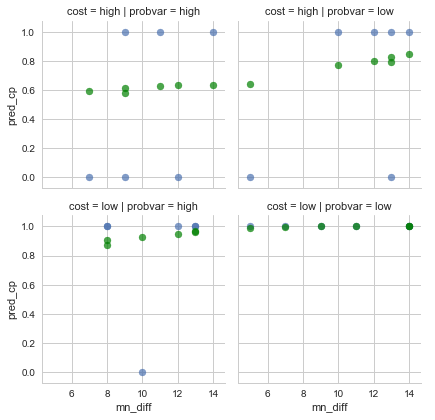

In [1333]:
g = sns.FacetGrid(pdf, col="probvar", row="cost")
g.map(plt.scatter, "mn_diff", "choseH", alpha=.7)
g.map(plt.scatter, "mn_diff", "pred_cp", alpha=.7, color='green')
g.add_legend();

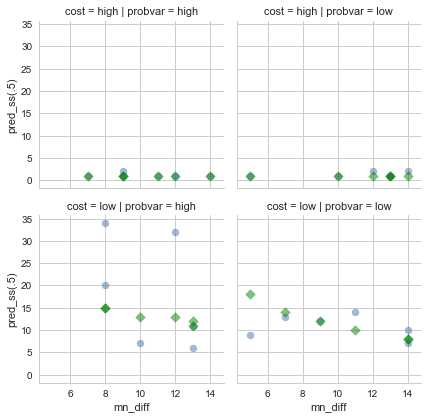

In [1334]:
g = sns.FacetGrid(pdf, col="probvar", row="cost")
g.map(plt.scatter, "mn_diff", "samplesize", alpha=.5)
g.map(plt.scatter, "mn_diff", "pred_ss(.5)", marker='D', alpha=.5, color='green')
g.add_legend();

In [1274]:
pdf.iloc[0]

subject                 217
gameind                   9
problem           normal-54
probvar                high
cond_color             same
cond_ecology         normal
cost                   high
samplesize                1
n_switch                  0
choice                    0
choseH                    0
mn_diff                   7
p_switch                  0
c_sigma             13.6388
sc                 0.130124
tau_trunc           2.39596
theta               4.77783
pred_cp               0.619
pred_ss(.25)              1
pred_ss(.5)               1
pred_ss(.75)              1
pred_ss_L(.25)            1
pred_ss_L(.5)             1
pred_ss_L(.75)            1
pred_ss_H(.25)            1
pred_ss_H(.5)             1
pred_ss_H(.75)            1
Name: 2361, dtype: object

217


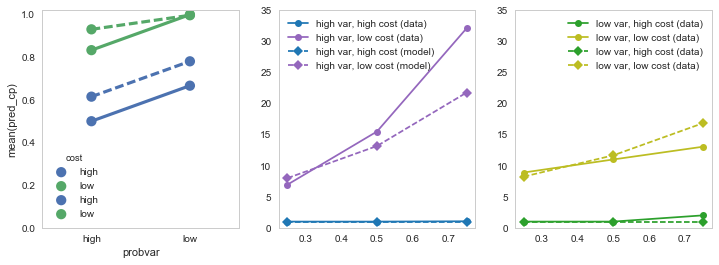

In [1335]:
stoprule = 'optional'



#for sid in data.subject.unique():
for sid in [217]:

    print sid
    
    sdf = df[(df.subject==sid) & (df.stoprule==stoprule)]

    fig, ax = plt.subplots(1, 3, figsize=(12,4))
    axi = ax[0]
    sns.pointplot(x='probvar', y='choseH', hue='cost', data=sdf, ax=axi)
    sns.pointplot(x='probvar', y='pred_cp', hue='cost', data=sdf, ax=axi, linestyles='--')
    axi.set_ylim(0, 1.02)


    cols = [tableau20[0], tableau20[8], tableau20[4], tableau20[16]]

    highvar_highcost = sdf[(sdf.probvar=='high') & (sdf.cost=='high')]
    highvar_lowcost = sdf[(sdf.probvar=='high') & (sdf.cost=='low')]

    lowvar_highcost = sdf[(sdf.probvar=='low') & (sdf.cost=='high')]
    lowvar_lowcost = sdf[(sdf.probvar=='low') & (sdf.cost=='low')]


    q = [.25, .5, .75]
    cols_obs  = ['ss(.25)', 'ss(.5)', 'ss(.75)']
    cols_pred = ['pred_ss(.25)', 'pred_ss(.5)', 'pred_ss(.75)']

    axi = ax[1]
    axi.plot(q, highvar_highcost[cols_obs].values[0], '-o', color=cols[0], label='high var, high cost (data)')
    axi.plot(q, highvar_lowcost[cols_obs].values[0], '-o', color=cols[1], label='high var, low cost (data)')
    axi.plot(q, highvar_highcost[cols_pred].values[0], '--D', color=cols[0], label='high var, high cost (model)')
    axi.plot(q, highvar_lowcost[cols_pred].values[0], '--D', color=cols[1], label='high var, low cost (model)')
    axi.legend()
    axi.set_ylim(0,35)

    axi = ax[2]
    axi.plot(q, lowvar_highcost[cols_obs].values[0], '-o', color=cols[2], label='low var, high cost (data)')
    axi.plot(q, lowvar_lowcost[cols_obs].values[0], '-o', color=cols[3], label='low var, low cost (data)')
    axi.plot(q, lowvar_highcost[cols_pred].values[0], '--D', color=cols[2], label='low var, high cost (data)')
    axi.plot(q, lowvar_lowcost[cols_pred].values[0], '--D', color=cols[3], label='low var, low cost (data)')
    axi.legend()
    axi.set_ylim(0,35)

    for axi in ax:
        axi.grid(False)
        #axi.set_ylim(0, 20)

    plt.show()

In [1304]:
np.sqrt([15, 800]) ** .1

array([ 1.14499756,  1.3968652 ])